### Is determinism correlated with token probabilities?

Contact: Breck Baldwin, breck_baldwin@gmail.com

Location of this notebook: 
https://github.com/breckbaldwin/llm-stability/blob/main/experiments/logprob/analysis.ipynb

It is possible that the probability associated with a LLM response could predict 
the determinism of the output. Determinism is defined to be: did the LLM give 
the same result for the same inputs--see https://arxiv.org/abs/2408.04667 for 
more details on what we are up to. Top P/K is set to 1 and temperature is set 
to 0.0 which we have found to be the most determinstic settings. 

This came about because of a comment on the reddit thread:
https://www.reddit.com/r/LocalLLaMA/comments/1j232am/measuring_the_determinism_of_sharedjob_and_onejob/

u/randomfoo2: "Also, you might want to do best of n and figure out what 
consensus you need to get what cutoffs on score. I bet it's probably lower than 
one might think (n=8?) to get a p=95 score, but something that someone would 
need to run the experiments with to verify. "

TL;DR I could not find any correlation with determinism and token 
probability--confirming that we are in some softmax hell of uselessly normalized 
scores to a 0-1 range.  

#### Approach

I created `run_logprob.py`, a sibling to this notebook in the directory, to 
run and collect the log probabilities for LLM responses for our experimental 
setup. The data set is the college math task from Measuring Massive Multitask
Language Understanding (MMLU) (https://arxiv.org/abs/2009.03300) pulled from the 
fine folks at Hugging Face (https://huggingface.co/datasets/cais/mmlu). I 
selected it since the task was very non-deterministic across many models in our
non-determinism expriments referenced above. The LLMs run were:

- GPT-4o, GPT-3.5: Open AI endpoints (https://openai.com/api/).
- Mixtral 8x7B, Llama 3 8b: Together AI endpoints (https://www.together.ai).
- Bimodal simulation: Simulation of ideal distribution of probabilities with 
concentrations around 0 for non-deterministic outputs and 1 for deterministic. 
- Deterministic simulation: Probability of response is correlated tightly to 
degree of non-determinsim.

LLMs are run via `python run_logprob.py` and results from previous runs are in
 `runs.tgz`. 

The steps are:

1. Run the 100 rubrics in MMLU college math 5 times against each model and 
collect the tokenized logprobs.
2. Each run is stored in a csv file, e.g., run 3 for GPT-4o is: `runs/gpt-4o_OAI-0.0-college_mathematics-0_2025-03-25_17-51-35/gpt-4o_OAI-0.0-college_mathematics-0-3.csv`
3. The column `logprobs` contains a list of tokens and logprobs for the LLM 
response: 

```
    [
    {
        "token": "To",
        "logprob": -0.021343659609556198
    },
    {
        "token": " determine",
        "logprob": -0.7634583711624146
    },
    ...
    ]
```

4. Parse out the answer from the response tokens, e.g., '(A)':

```
    [
    {
        "token": "(",
        "logprob": -1.8898618182391718
    },
    {
        "token": "A",
        "logprob": -1.8898618182391718
    },
    {
        "token": ")",
        "logprob": -1.8898618182391718
    }
    ]

```

5. Calculate the average probability of the response and the answer.

6. Calculate the number of string equivalent responses across the 5  
runs. This results in MACr (maximum agreement count raw) scores represented as 
1/5..5/5 indicating the largest count of runs with the same response at the 
string level. 5/5 means that all 5 runs had the same string result. 
7. Graph the results.





### Load in the data

In [1]:
import pandas as pd
import glob
import os
import json
import sys
import importlib

import tarfile

# Extract runs.tgz to current directory
if not os.path.exists('runs'):
    with tarfile.open('runs.tgz', 'r:gz') as tar:
        tar.extractall()


files = glob.glob(os.path.join('runs', '**', '*.csv'), 
                        recursive=True)
data_df = pd.DataFrame()
for csv_file in files:
    csv_df = pd.read_csv(csv_file)
    print(f"Trying {csv_file}")
    for col in ['prompt', 'model_config', 'task_config', 'rubric', 'logprobs']:
        csv_df[col] = csv_df[col].apply(lambda cell: json.loads(cell))
    csv_df['file'] = csv_file
    data_df = pd.concat([data_df, csv_df], ignore_index=True)



Trying runs/gpt-4o_OAI-0.0-college_mathematics-0_2025-03-25_17-51-35/gpt-4o_OAI-0.0-college_mathematics-0-4.csv
Trying runs/gpt-4o_OAI-0.0-college_mathematics-0_2025-03-25_17-51-35/gpt-4o_OAI-0.0-college_mathematics-0-1.csv
Trying runs/gpt-4o_OAI-0.0-college_mathematics-0_2025-03-25_17-51-35/gpt-4o_OAI-0.0-college_mathematics-0-0.csv
Trying runs/gpt-4o_OAI-0.0-college_mathematics-0_2025-03-25_17-51-35/gpt-4o_OAI-0.0-college_mathematics-0-2.csv
Trying runs/gpt-4o_OAI-0.0-college_mathematics-0_2025-03-25_17-51-35/gpt-4o_OAI-0.0-college_mathematics-0-3.csv
Trying runs/mixtral-8x7b-0.0-college_mathematics-0_2025-03-27_13-17-57/mixtral-8x7b-0.0-college_mathematics-0-0.csv
Trying runs/mixtral-8x7b-0.0-college_mathematics-0_2025-03-27_13-17-57/mixtral-8x7b-0.0-college_mathematics-0-1.csv
Trying runs/mixtral-8x7b-0.0-college_mathematics-0_2025-03-27_13-17-57/mixtral-8x7b-0.0-college_mathematics-0-3.csv
Trying runs/mixtral-8x7b-0.0-college_mathematics-0_2025-03-27_13-17-57/mixtral-8x7b-0.0-coll

### Evaluate data and put in dataframe for graphing

The questions are all multiple choice but the LLMs often gave background reasoning
to support thier answers. 

The answers tended to be 3 tokens, e.g., ' (', 'A', ')'. The entire response 
could be much longer, e.g., 


```The equation e^x + x - 2 = 0 can be rewritten as e^x = 2 - x. 

Let f(x) = e^x - x - 2. 

f(0) = e^0 - 0 - 2 = 1 - 2 = -1
f(1) = e^1 - 1 - 2 = e - 3 ≈ 0.718

Since f(x) is continuous and f(0) < 0 < f(1), by the Intermediate Value Theorem, there exists at least one solution in the interval [0, 1]. 

Now, let's find the derivative of f(x) to determine the behavior of the function:

f'(x) = e^x - 1

f'(x) = 0 when e^x = 1, which occurs when x = 0. 

Since f'(x) is positive for x < 0 and negative for x > 0, we can conclude that f(x) has a local maximum at x = 0. 

Therefore, there is exactly one real solution in the interval [0, 1]. 

Since there is only one real solution in the interval [0, 1], n = 0. 

Therefore, the correct answer is (B) k = 1 and n = 0.
```

- Determine the probability the answer. Sometimes we fail to find the answer which is encoded via a probability of 1.1.
- Determine the probability of the entire response. 
- Both are averaged to token length to normalize values for length, i.e., longer sequences will be less probable by definition so we divide by number of tokens to get an average. Answers can have more than one token, '(A)' tokenizes as `'(', 'A', ')'`, so averaging applies there too. 




In [2]:
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import evaluate
from collections import defaultdict
from answer_parser import parse_paren_answers_with_weights 
import math
# get answer's logprob
# Follows the evaluation code in evaluate.py at the top level of the repo
configs = evaluate.get_experiment_configs(data_df)
task_x_rubric = set()
total_evals = 0
disp_df = pd.DataFrame()
for model, model_config, task, task_config in configs:
    try:
        task_module = importlib.import_module(f'tasks.{task}')
    except ModuleNotFoundError:
        print(f'Need to add {f"tasks.{task}"}, skipping eval')
        continue
    results = pd.DataFrame()
    exp_df = data_df[(data_df['model'] == model)
                        & (data_df['model_config'] == model_config)
                        & (data_df['task'] == task)
                        & (data_df['task_config'] == task_config)]
    #print(f"{model} {model_config} {task} {task_config}")
    if len(exp_df.index) == 0: #may have combos with no data
        continue
    rubric_ids = exp_df['rubric_id'].unique()
    num_questions = len(rubric_ids)
    num_runs = max(exp_df['run']) + 1
    for id in rubric_ids:
        task_x_rubric.add(f"{task}x{id}")
        question_df = exp_df[exp_df['rubric_id'] == id]
        raw = defaultdict(int)
        answer = defaultdict(int)
        if not num_runs == len(question_df.index):
            print(f"{model}, {model_config}, {task}, {task_config}")
            error = f"runs not matching expected length, expected {num_runs}, got {len(question_df.index)} for {question_df['file'].to_list()}"
            raise IndexError(error)
        corrects_for_rubric = 0
        run_accum = [0] * num_runs
        prob_accum = []
        logprob_accum = []
        answers_accum = []
        response_token_logprob_accum = []
        response_token_avg_logprob_accum = []
        response_token_avg_prob_accum = []
        token_lp_accum = []
        
        for idx, row in question_df.iterrows(): # runs over question
            raw[task_module.raw_fn(row)] += 1
            total = 0
            tok_lp_list = []
            for pr in row['logprobs']:
                total += pr['logprob']
                tok_lp_list.append(pr['logprob'])
            token_lp_accum.append(tok_lp_list)
            avg_logprob = total/len(row['logprobs'])
            response_token_avg_logprob_accum.append(avg_logprob)
            response_token_avg_prob_accum.append(math.exp(avg_logprob))
            total_evals += 1
            if pd.isna(row['response']): #no LLM response
                #errors.append(f"NaN response found {model} {task} {id}")
                prob_accum.append(1.3)
                logprob_accum.append(.3)
                answers_accum.append('na')
                continue
            try:
                parsed_answer = task_module.answer_fn(row, task_config)
                if parsed_answer is None:
                    error = f"No answer found {model} {task} {id}"
                    #print(error)
                    #print(f"Response: {row['response']}")
                    prob_accum.append(1.1)
                    logprob_accum.append(.1)
                    answers_accum.append('No Answer Found')
                    continue # cannot be correct so continue
                else:
                    data_df.loc[idx,'parsed_answer'] = parsed_answer
                    answer[parsed_answer] += 1
                    answer_2 = \
                        parse_paren_answers_with_weights([parsed_answer], row)
                    if answer_2 is None:
                        print("Unable to parse previously parsable answer")
                        print(f"Response: {row['response']}")
                    data_df.loc[idx,'logprob'] = answer_2[parsed_answer]
                    logprob_accum.append(answer_2[parsed_answer])
                    prob_accum.append(math.exp(answer_2[parsed_answer]))
                    answers_accum.append(parsed_answer)
            except LookupError as e: #LookupError is 
                answer[idx] += 1 # Blown UP is also a failure of TARa
                data_df.loc[idx,'parsed_answer'] = "Blown UP"
                error = f"Blown UP found {model} {task} {id} Answer: {e}"
                prob_accum.append(1.1)
                logprob_accum.append(.1)
                answers_accum.append('BUP')
                continue # can't be correct so continue
            if task_module.correct_fn(row, task_config):
                #correct[row['run']] += 1
                run_accum[row['run']] = 1
                data_df.loc[idx,'correct'] = True
                corrects_for_rubric += 1
                #correct_raw_to_count[task_module.raw_fn(row)] += 1
            #else:
                #incorrect_raw_to_count[task_module.raw_fn(row)] += 1
        runs_df = pd.DataFrame({'answer prob': prob_accum,
                                'response prob': response_token_avg_prob_accum,
                                'answer logprob': logprob_accum,
                                'answer': answers_accum})
        runs_df['id'] = id
        runs_df['task'] = task
        runs_df['MARr'] = max(raw.values())/num_runs
        runs_df['MACr'] = f"{max(raw.values())}/{num_runs}"
        #runs_df['MACr correct']
        #runs_df['MACr incorrect']
        runs_df['model'] = model
        disp_df = pd.concat([disp_df, runs_df], ignore_index=True)
        

/Users/bb/git/S3rd/content/LLM_UI/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plot results

You will have to install R to run this cell--it calls the R code as a system call instead of running it in the notebook--I think I did you a favor by not having the notebook be a hybrid of R/Python--I at least was struggling to get it working. 

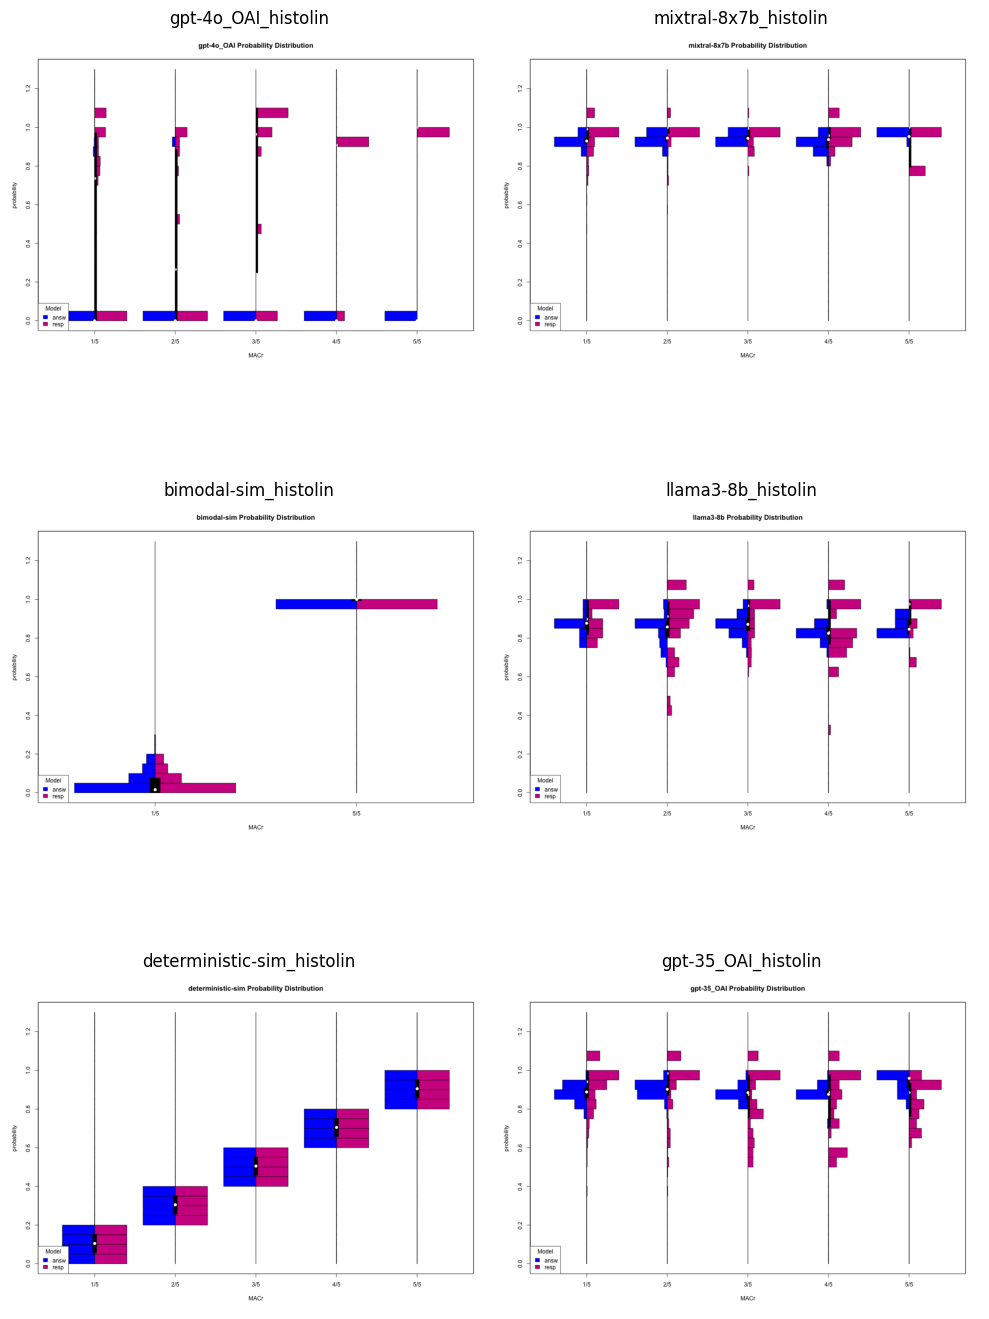

In [3]:
import subprocess
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to R script
r_script = 'histolin_plot.R'
data_dir = 'plots' #relative to notebook
output_files = []


# Generate plots via Rscript
for model in disp_df['model'].unique():
    answer_file = os.path.join(data_dir, f'{model}_answ.csv')
    resp_file = os.path.join(data_dir, f'{model}_resp.csv')
    output_file = f'plots/{model}_histolin.png'
    title = f'{model} Probability Distribution'
    model_df = disp_df[disp_df['model'] == model]
    melted_export_df = model_df.melt(
        id_vars=['MACr'],
        value_vars=['answer prob', 'response prob'],
        var_name='prob_type',
        value_name='probability'
    )
    melted_export_df[melted_export_df['prob_type'] == 'answer prob'].to_csv(answer_file)
    melted_export_df[melted_export_df['prob_type'] == 'response prob'].to_csv(resp_file)

    result = subprocess.run(
        ['Rscript', r_script, answer_file, resp_file, output_file, title],
        capture_output=True, text=True
    )

    if result.returncode != 0:
        print(f"Error processing {model}:\n{result.stderr}")
    else:
        output_files.append(output_file)

# Load and combine images into a grid using matplotlib
ncols = 2
nrows = (len(output_files) + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))

# Flatten axes for easier indexing
axes = axes.flatten() if len(output_files) > 1 else [axes]

for ax, file in zip(axes, output_files):
    img = Image.open(file)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.splitext(os.path.basename(file))[0], fontsize=12)

# Hide unused subplots if total < nrows*ncols
for i in range(len(output_files), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


The above plots are violin style plots with a histogram replacing the KDE (kernel     
density estimation). I used the R package `vioplot`, code is in `histolin_plot.R`.   
KDE assumes each datapoint comes from a normal/Gaussian distribution which we        
don't know to be the case so I prefer a non-smoothed representation that is         
distinctly less violin like. I went with the portmanteau 'histolin'.                
                                                                                     
Each plot represents 5 runs of 100 questions for college mathematics, so 1,000       
datapoints including answers and entire responses. There is additionally             
simulated output that maps determinism to probability. Discussion of the             
simulation is below.                                                                 
                                                                                     
The MACr is the maximum agreement count for raw outputs--the smallest number of      
possible agreements is 1, meaning no output agrees with the output of any of the     
other 5 runs, 5/5 means that all the runs produced the exact same output. The       
average token probability of the parsed out answer is on the left in blue, the       
average token probability of the entire response is on right in red. The             
'probability' of 1.1 corresponds to a failed parse for some reason, 1.2 is           
reserved for no LLM response but that never happened.                                



### Analysis

What we might expect is that the LLMs show calibration with respect to 
determinism, e.g., when they are non-deterministic they have lower probability, 
higher probability or some discernable pattern that allows us to predict whether 
the results was deterministic or not. 

The plot bimodal-sim_histolin shows an ideal distribution where all the 5/5 
results are at 1.0 and all the other results are at 1/5--no in-between MACr 
values as well--see `llm-stability/models/bimodal-sim.py` for details. 

- Rubric 0-49: Probability ~0% -> MACr = 1/5
- Rubric 50-99: Probability ~100% -> MACr = 5/5

A more 'reasonable' simulation, deterministic-sim_histolin, distributes 
probabilities uniformly between 0 and 1 as follows--
see `llm-stability/models/deterministic-sim.py` for details:

- Rubric 0-19: Probability [0%-20%) -> MACr = 1/5
- Rubric 20-39: Probability [20%-40%) -> MACr = 2/5
- Rubric 40-59: Probability [40%-60%) -> MACr = 3/5
- Rubric 60-79: Probability [60%-80%) -> MACr = 4/5
- Rubric 80-99: Probability [80%-100%] -> MACr = 5/5

One could then engineer a system to accept proabilities > .8 as deterministic. 

On examination of the non-simulation plots I don't see any relationship between 
either answer probability or response probability and MACr == 5/5. The graph for gpt-4o_OAI_histolin seems to have the plots at low probability but no obvious 
difference between varios MACr levels.   

All code is in the repo if you wish to explore the details/reproduce/fix my 
mistakes....

Breck